In [19]:
from sklearn.model_selection import train_test_split
import pandas as pd

import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import numpy as np

In [20]:
df = pd.read_csv("data/Bank Customer Churn Prediction.csv")
target_col = 'churn'
cols_to_drop = ['customer_id', target_col]

Dataset taken from here: https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset 

1. Fit Model
2. Feature Importance from Lightgbm
3. Predict on new-test loans
4. Shap Feature Importance
5. LGB inference Feature Importance

--- 
Preparing Model

In [21]:
categorical_columns = df.drop(cols_to_drop, axis=1).select_dtypes(include=['object']).columns

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate with original data frame minus categorical columns
df = pd.concat([df.drop(categorical_columns, axis=1), encoded_df], axis=1)

In [22]:
# Train-test holdout split
X_train, X_test, y_train, y_test = train_test_split(df.drop(cols_to_drop, axis=1), df[target_col], test_size=0.3, random_state=42)

# LightGBM handling
idx = X_train.query("(products_number >= 3 & country_Germany == 0) | (country_Germany == 1)").index
lgb_train = lgb.Dataset(X_train.loc[idx], y_train.loc[idx])
lgb_test = lgb.Dataset(X_test, y_test)

# Train model using LGBClassifier
# lgb_classifier = lgb.LGBMClassifier()
# lgb_classifier.fit(X_train_le, y_train)  # Using label encoded data as example

# Train model using lgb.train
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': 'false',
    'boosting': 'gbdt',
    'feature_fraction': 0.5,
    'learning_rate': 0.05,
    'max_depth': 5,
    'verbose': -1
}
NUM_BOOST_ROUND = 100
lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_test, num_boost_round=NUM_BOOST_ROUND)

Compare Feature Importance:

1. lightgbm classical feature importance
2. shap feature importance
3. new inference feature importance

---

Possible comparisons:

1. Feature Magnitude
2. Timing
3. Select subset of features where lightgbm classical feature importance is not useful

--- 



<Axes: >

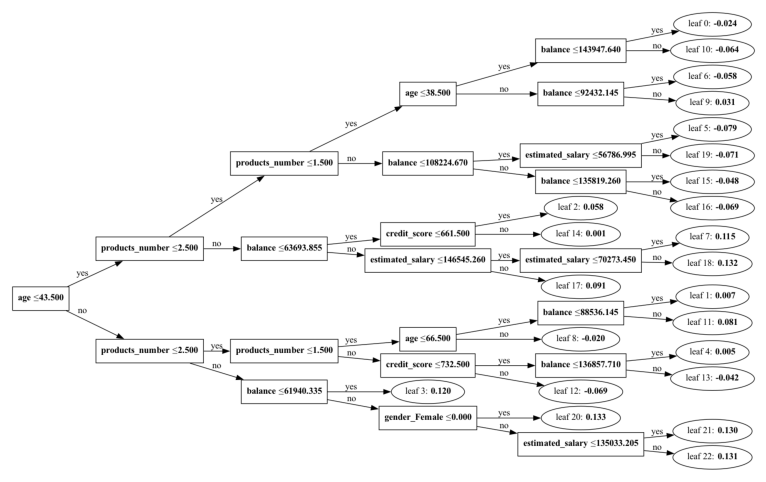

In [5]:
lgb.plot_tree(lgb_model, tree_index=1, figsize=(20, 6))

In [6]:
X_train

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_France,country_Germany,country_Spain,gender_Female,gender_Male
9069,619,32,4,175406.13,2,1,1,172792.43,0.0,0.0,1.0,1.0,0.0
2603,643,34,7,160426.07,1,0,1,188533.11,0.0,1.0,0.0,1.0,0.0
7738,561,33,6,0.00,2,0,0,173680.39,1.0,0.0,0.0,0.0,1.0
1579,618,41,8,37702.79,1,1,1,195775.48,0.0,1.0,0.0,0.0,1.0
5058,714,37,9,148466.93,2,0,1,151280.96,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,768,54,8,69712.74,1,1,1,69381.05,1.0,0.0,0.0,0.0,1.0
5191,682,58,1,0.00,1,1,1,706.50,1.0,0.0,0.0,1.0,0.0
5390,735,38,1,0.00,3,0,0,92220.12,1.0,0.0,0.0,1.0,0.0
860,667,43,8,190227.46,1,1,0,97508.04,1.0,0.0,0.0,0.0,1.0


In [20]:
import shap
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)
shap_values_df = pd.DataFrame(shap_values, columns = lgb_model.feature_name())
shap_feature_importance = shap_values_df.abs().mean(axis=0).rename('feature_importance').rename_axis('feature').reset_index().sort_values('feature_importance', ascending=False, ignore_index=True)

/Users/tommasoguerrini/Projects/lgb_feature_importance/.conda/lib/python3.11/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [21]:
lgb_model_feature_importance = (pd.DataFrame({'feature': lgb_model.feature_name(), 
                                'feature_importance': lgb_model.feature_importance(importance_type='gain')})
                               .sort_values('feature_importance', ascending=False, ignore_index=True))

In [6]:
(lgb_model.trees_to_dataframe().groupby('split_feature').split_gain.sum().rename('feature_importance')
.reset_index(drop=False)
.sort_values('feature_importance', ascending=False, ignore_index=True))

,split_feature,feature_importance
0,country_Germany,203.751007
1,gender_Female,81.054901
2,credit_score,20.476411
3,tenure,10.487700


In [70]:
from joblib import Parallel, delayed

def get_node_path(tree_df: pd.DataFrame, tree_index: int, node_index: str):
    """
    Retrieves the path from the given node to the root in a tree structure.

    Args:
        tree_df (DataFrame): Dataframe containing the tree structure.
        tree_index (int): The index of the tree to query.
        node_index (str): The node index from which to trace the path to the root.

    Returns:
        list: The path (as a list of node indices) from the specified node to the root.
    """
    path = []
    current_index = node_index
    while current_index != '0':
        row = tree_df[(tree_df['tree_index'] == tree_index) & (tree_df['node_index'] == current_index)]
        if row.empty or current_index == '-1':
            break
        path.append(current_index)
        current_index = row.iloc[0]['parent_index']
    return path[::-1]

def get_node_index(leaf_indices: np.array):
    """
    Converts leaf indices from a tree model into a tabular format with node indices and prediction numbers.

    Args:
        leaf_indices (np.array): Array containing the indices of leaf nodes where rows correspond to samples and columns to trees.

    Returns:
        DataFrame: Dataframe with columns 'node_index' and 'pred_number' listing node indices and the corresponding prediction number.
    """
    
    num_samples, num_trees = leaf_indices.shape
    leaf_indices_str = np.core.defchararray.add(np.arange(num_trees).astype(str), np.core.defchararray.add("-L", leaf_indices.astype(str)))

    return pd.DataFrame({
        'node_index': leaf_indices_str.ravel(),
        'pred_number': np.repeat(np.arange(num_samples), num_trees)
    })

def get_inference_feature_importance(model: lgb.Booster, subset_df: pd.DataFrame, return_raw: bool = False):
    """
    Calculates feature importance based on inference on a subset, using leaf contributions to overall predictions.

    Args:
        model (lgb.Booster): The trained LightGBM model.
        subset_df (DataFrame): The subset of data on which to perform inference.
        return_raw (bool): Whether to return also the non-aggregated dataframe before feature importance.

    Returns:
    pd.DataFrame: A DataFrame containing metrics of feature importance, sorted by 'w_n_splits' in descending order. The columns included are:
        - split_feature (str): The name of the feature used in the split.
        - n_splits (int): The number of times the feature is used to split the data across all trees.
        - w_n_splits (float): The weighted count of splits, where each split is weighted by the relative_weight at that node.
        - n_paths (int): The number of unique paths that include the feature across all trees, considering only unique occurrences in each path.
        - w_n_paths (float): The weighted count of unique paths, where each path's contribution is again weighted by the relative_weight at nodes that include the feature.,
    pd.DataFrame: A DataFrame with the expanded model.trees_to_dataframe() used to calculate feature importance at inference time
    """

    leaf_indices = model.predict(subset_df[model.feature_name()], pred_leaf=True)
    tree_df = (model.trees_to_dataframe())

    results = Parallel(n_jobs=-1)(
        delayed(get_node_path)(tree_df, row['tree_index'], row['node_index'])
        for _, row in tree_df.iterrows())

    tree_df['path'] = results
    
    pred_leaf = get_node_index(leaf_indices)
    leaf_value = (tree_df
                  .assign(leaf_value=lambda x: (x.value)*(x.node_index.str.contains('-L'))).assign(abs_value=lambda x: abs(x.leaf_value)))
    
    expanded_df = (leaf_value
        .merge(pred_leaf, on = ['node_index'])[['node_index', 'tree_index', 'value', 'abs_value', 'pred_number', 'path']].explode('path')
        .merge(tree_df[['node_index', 'split_feature', 'threshold', 'split_gain']].rename({'node_index': 'path'}, axis=1), on = ['path'])
        .assign(total_value=lambda x: x.abs_value.sum(), relative_weight=lambda x: (x.abs_value/x.total_value)))
    
    split_stats = (expanded_df.groupby('split_feature').agg(n_splits=('split_feature', 'count'), w_n_splits=('relative_weight', 'sum'))
                   .reset_index())
    path_stats = (expanded_df.groupby(['split_feature', 'node_index', 'relative_weight'])
                             .agg(n_paths=('pred_number', 'nunique')).reset_index()
                             .assign(w_n_paths=lambda x: (x.relative_weight*x.n_paths))
                             .groupby('split_feature')[['n_paths', 'w_n_paths']].sum().reset_index())
    
    return (split_stats.merge(path_stats, on = ['split_feature']).sort_values('w_n_splits', ascending=False, ignore_index=True)), expanded_df

In [72]:
inference_fi, expanded_df = get_inference_feature_importance(lgb_model, X_test.head(1))

In [73]:
inference_fi

,split_feature,n_splits,w_n_splits,n_paths,w_n_paths
0,products_number,106,0.174243,55,0.088642
1,age,96,0.169193,50,0.082605
2,balance,90,0.132613,51,0.084811
3,estimated_salary,46,0.079867,39,0.076519
4,credit_score,58,0.070077,39,0.061471
5,gender_Female,17,0.059368,17,0.059368
6,country_Germany,16,0.045787,16,0.045787
7,tenure,28,0.045064,19,0.038733
8,active_member,28,0.022352,28,0.022352
9,credit_card,4,0.013431,4,0.013431


In [81]:
pd.concat([shap_feature_importance.assign(shap_fi=lambda x: (x.feature_importance/x.feature_importance.sum())).drop('feature_importance', axis=1).head(20), 
           lgb_model_feature_importance.assign(lgb_classic=lambda x: (x.feature_importance/x.feature_importance.sum())).drop('feature_importance', axis=1).head(20), 
           inference_fi.head(20).rename({'feature_importance': 'lgb_inference'}, axis=1)], axis=1)

,feature,shap_fi,feature,lgb_classic,feature,n_splits,lgb_inference
0,products_number,0.270820,age,0.261392,credit_score,236774,0.151417
1,age,0.253210,products_number,0.200052,age,312196,0.116063
2,active_member,0.116244,balance,0.149078,estimated_salary,195953,0.112814
3,balance,0.076873,credit_score,0.110753,products_number,282124,0.108351
4,country_Germany,0.060715,estimated_salary,0.095635,balance,273347,0.092991
5,gender_Female,0.054053,active_member,0.051636,country_Germany,65777,0.075831
6,credit_score,0.039320,tenure,0.042862,gender_Female,49079,0.069688
7,estimated_salary,0.035001,country_Germany,0.035597,tenure,90453,0.063974
8,tenure,0.028067,gender_Female,0.017360,active_member,75259,0.024304
9,country_France,0.026440,country_France,0.012849,country_Spain,19604,0.010639


---

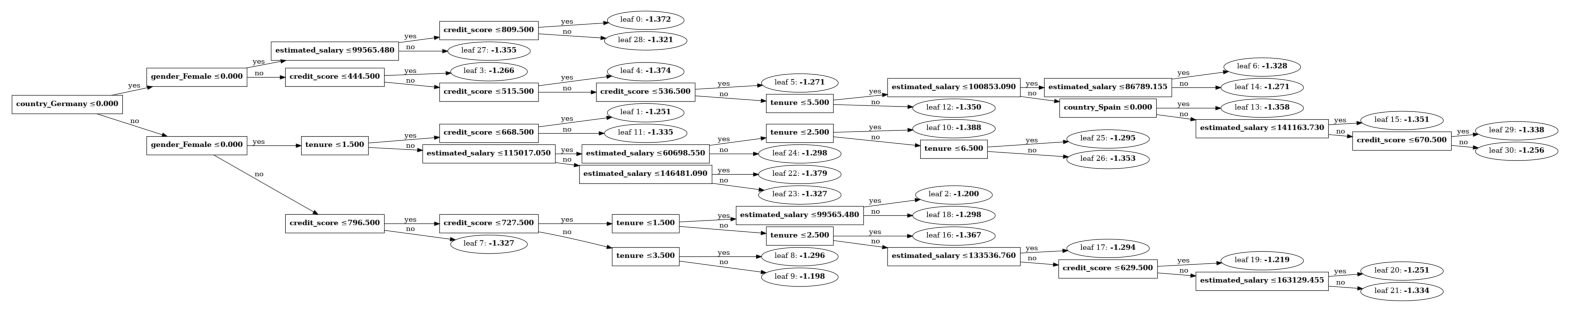

In [24]:
lgb.plot_tree(lgb_model, tree_index=0, figsize=(20, 6));

In [14]:
tree_df = lgb_model.trees_to_dataframe()

In [22]:
(tree_df.groupby(['split_feature', 'threshold']).agg(n_splits=('split_feature', 'count'), total_gain_split=('split_gain', 'sum')).reset_index()
.merge(tree_df.groupby('split_feature').split_gain.sum().rename('total_gain').reset_index(), on = ['split_feature'])
.assign(relative_split_threshold_importance=lambda x: (x.total_gain_split/x.total_gain).round(5))
.sort_values('relative_split_threshold_importance', ascending=False, ignore_index=True)
.head(20))

,split_feature,threshold,n_splits,total_gain_split,total_gain,relative_split_threshold_importance
0,active_member,1.000000e-35,72,1107.176538,1107.176538,1.00000
1,gender_Female,1.000000e-35,69,372.240919,372.240919,1.00000
2,country_France,1.000000e-35,56,275.502289,275.502289,1.00000
3,country_Germany,1.000000e-35,85,763.270556,763.270556,1.00000
4,country_Spain,1.000000e-35,43,202.773920,202.773920,1.00000
5,credit_card,1.000000e-35,34,114.532410,114.532410,1.00000
6,gender_Male,1.000000e-35,47,171.295054,171.295054,1.00000
7,products_number,2.500000e+00,79,2250.554057,4289.516937,0.52466
8,products_number,1.500000e+00,89,2036.180820,4289.516937,0.47469
9,age,4.250000e+01,16,1507.749447,5604.762286,0.26901


---

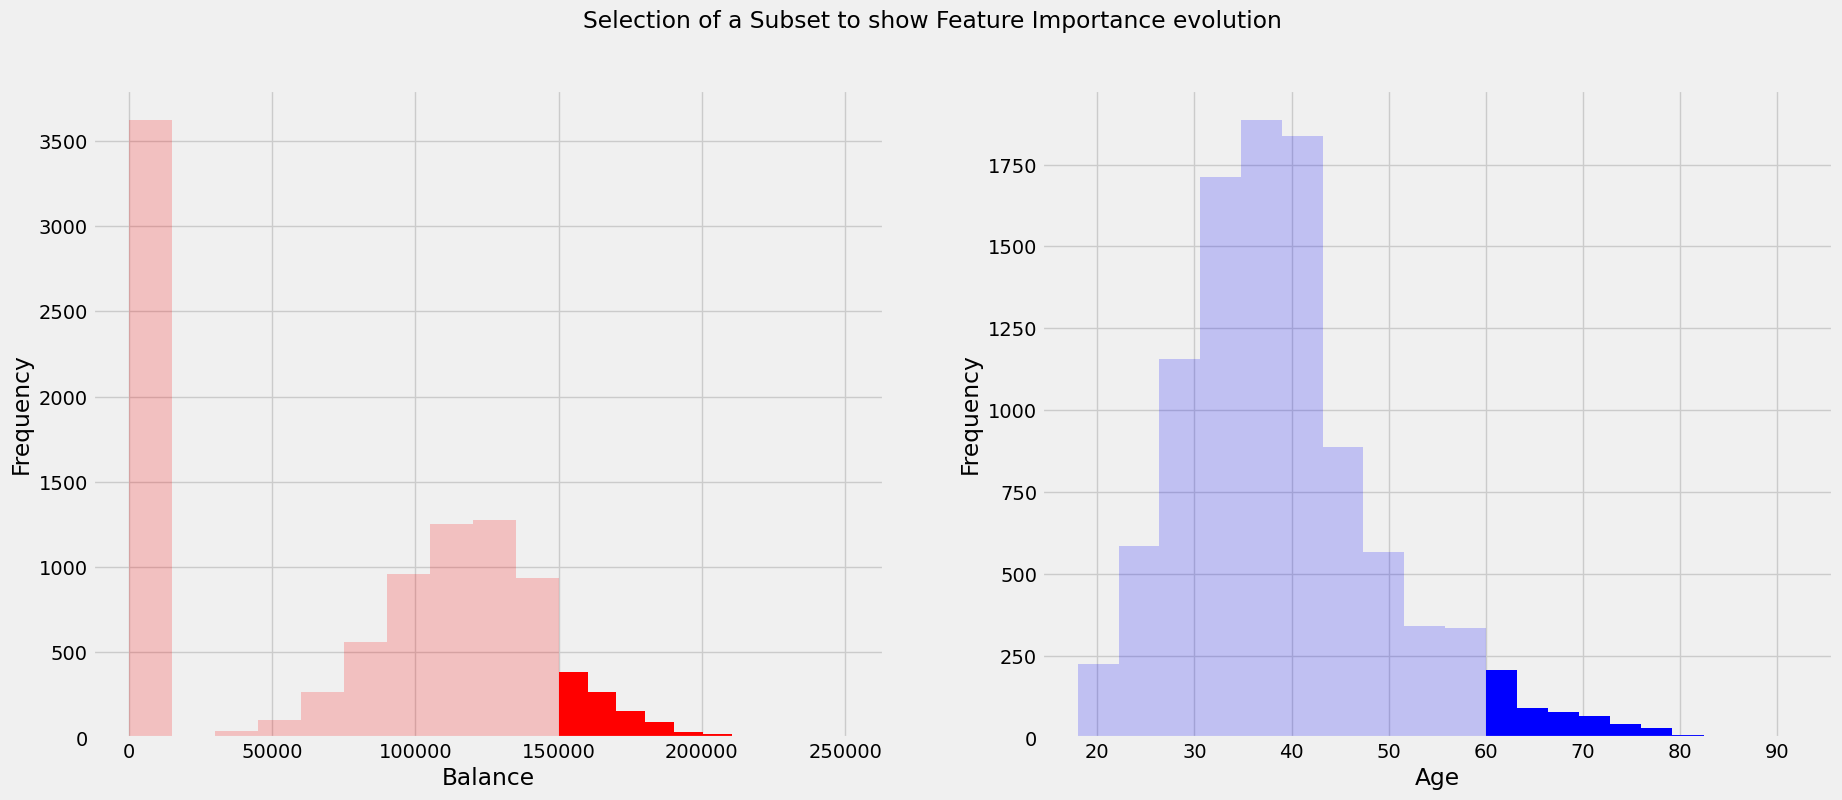

In [82]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
# Histogram with different opacities based on conditions
df.balance.hist(alpha=0.2, range=(df.balance.min(), 150000), color = 'red', ax=ax[0])
df.balance.hist(alpha=1.0, range=(150000, df.balance.max()), color = 'red', ax=ax[0])

df.age.hist(alpha=0.2, range=(df.age.min(), 60), color = 'blue', ax=ax[1])
df.age.hist(alpha=1.0, range=(60, df.age.max()), color = 'blue', ax=ax[1])

ax[0].set_xlabel('Balance')
ax[0].set_ylabel('Frequency')

ax[1].set_xlabel('Age')
ax[1].set_ylabel('Frequency')

plt.suptitle('Selection of a Subset to show Feature Importance evolution')
plt.show()

**Create a subset of test**:

- age above 60
- balance > 175000

In [83]:
subset_df = X_test.query("age > 60").query("balance > 150000").reset_index()

In [84]:
subset_fi, expanded_tree = get_inference_feature_importance(lgb_model, subset_df)

In [96]:
df.products_number.unique()

array([1, 3, 2, 4])

In [97]:
import json
import s3fs

fs = s3fs.S3FileSystem(anon=False)

RUN_ID = "783d3295a26c446ea1b78b9560a5791c"
with fs.open(f"s3://cardoai-mlflow-artifact-bucket/{RUN_ID}/artifacts/models/2023-01-02/model_2023-01-02.bin", 'rb') as f:
    data = f.read()

with open('local_model.bin', 'wb') as local_file:
    local_file.write(data)

model = lgb.Booster(model_file='local_model.bin')

In [98]:
tree_df = model.trees_to_dataframe()

In [104]:
(tree_df.groupby(['split_feature', 'threshold']).agg(n_splits=('split_feature', 'count'), total_gain_split=('split_gain', 'sum')).reset_index()
.merge(tree_df.groupby('split_feature').split_gain.sum().rename('total_gain').reset_index(), on = ['split_feature'])
.assign(relative_split_threshold_importance=lambda x: (x.total_gain_split/x.total_gain).round(5))
.query("total_gain>100")
.sort_values('relative_split_threshold_importance', ascending=False, ignore_index=True).head())

,split_feature,threshold,n_splits,total_gain_split,total_gain,relative_split_threshold_importance
0,n_status_2,1.000000e-35,15,233.504621,233.504621,1.00000
1,status,1.000000e-35,11,2166.134610,2169.435676,0.99848
2,lagged_status,1.000000e-35,17,172.725194,176.108230,0.98079
3,n_status_12,1.000000e-35,23,3923.064587,4000.690309,0.98060
4,ratio_status_12,1.000000e-35,7,1567.859796,1625.584109,0.96449


In [53]:
(expanded_tree.groupby(['split_feature', 'threshold']).agg(n_splits=('split_feature', 'count'), total_gain_split=('split_gain', 'sum')).reset_index()
.merge(expanded_tree.groupby('split_feature').split_gain.sum().rename('total_gain').reset_index(), on = ['split_feature'])
.assign(relative_split_threshold_importance=lambda x: (x.total_gain_split/x.total_gain).round(5))
.sort_values('relative_split_threshold_importance', ascending=False, ignore_index=True)
.head(20))

,split_feature,threshold,n_splits,total_gain_split,total_gain,relative_split_threshold_importance
0,active_member,1.000000e-35,462,10846.055019,10846.055019,1.00000
1,country_France,1.000000e-35,46,331.749331,331.749331,1.00000
2,country_Germany,1.000000e-35,295,4555.548868,4555.548868,1.00000
3,country_Spain,1.000000e-35,125,693.252764,693.252764,1.00000
4,gender_Female,1.000000e-35,168,1231.326424,1231.326424,1.00000
5,credit_card,1.000000e-35,29,101.635460,101.635460,1.00000
6,gender_Male,1.000000e-35,68,306.988436,306.988436,1.00000
7,products_number,2.500000e+00,623,23354.363629,44483.894090,0.52501
8,products_number,1.500000e+00,599,21123.966341,44483.894090,0.47487
9,age,4.250000e+01,140,20831.267754,55904.602032,0.37262


In [87]:
pd.concat([subset_fi.rename({'feature_importance': 'lgb_inference'}, axis=1), 
           lgb_model_feature_importance.rename({'feature_importance': 'lgb_classic'}, axis=1)
          .assign(lgb_classic=lambda x: (x.lgb_classic/x.lgb_classic.sum()).round(6))], axis=1)

,feature,n_splits,lgb_inference,feature,lgb_classic
0,credit_score,911,0.154886,age,0.261392
1,age,1520,0.140111,products_number,0.200052
2,estimated_salary,769,0.107967,balance,0.149078
3,products_number,1224,0.097698,credit_score,0.110753
4,balance,1111,0.083528,estimated_salary,0.095635
5,country_Germany,295,0.074222,active_member,0.051636
6,gender_Female,168,0.065139,tenure,0.042862
7,tenure,346,0.054766,country_Germany,0.035597
8,active_member,462,0.034473,gender_Female,0.017360
9,country_Spain,125,0.012732,country_France,0.012849


In [88]:
lgb_model_feature_importance['feature_importance'] = lgb_model_feature_importance.feature_importance/lgb_model_feature_importance.feature_importance.sum()

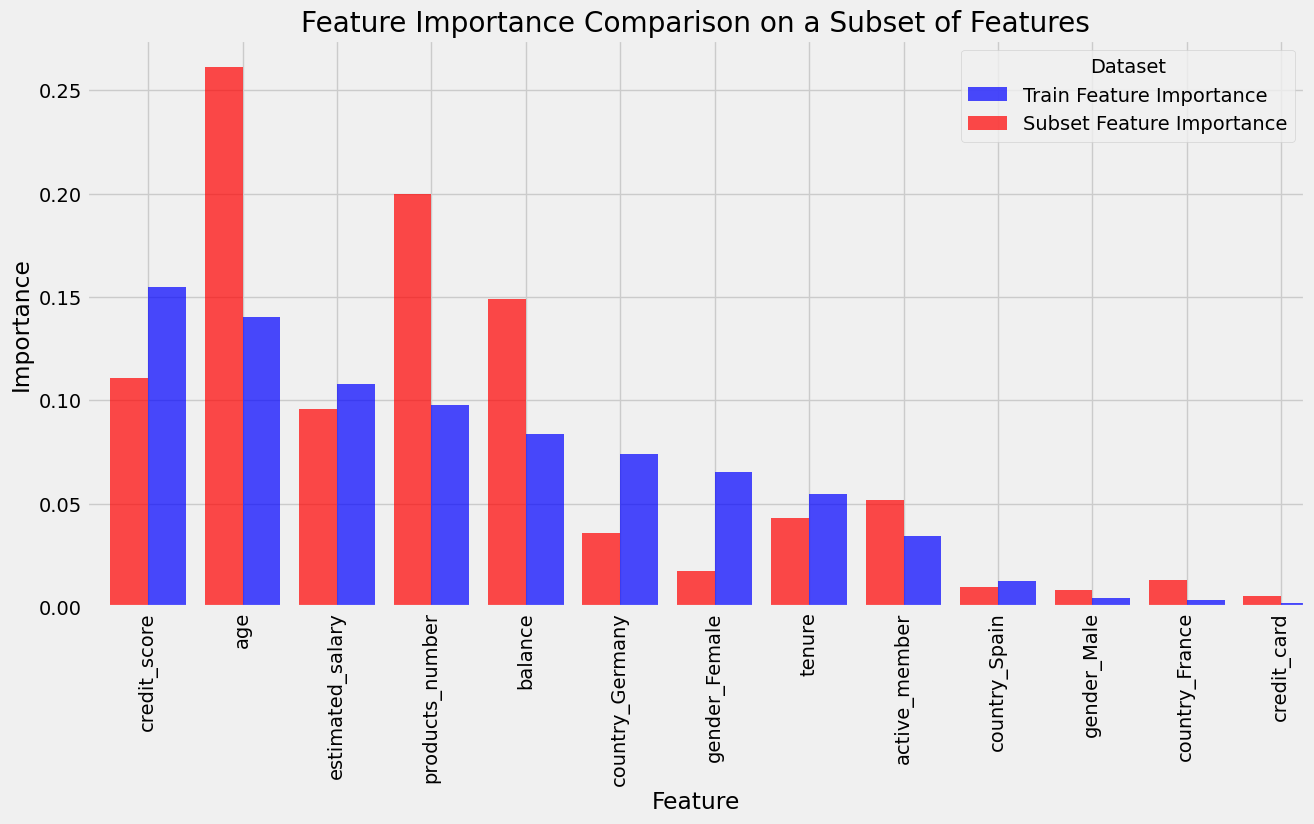

In [89]:
merged_df = subset_fi.merge(lgb_model_feature_importance, on='feature', suffixes=('_df1', '_df2'))
merged_df.sort_values(by='feature_importance_df1', ascending=False, inplace=True)
# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
merged_df.plot(x='feature', y='feature_importance_df1', kind='bar', ax=ax, color='blue', position=0, width=0.4, alpha=0.7, label='Train Feature Importance')
merged_df.plot(x='feature', y='feature_importance_df2', kind='bar', ax=ax, color='red', position=1, width=0.4, alpha=0.7, label='Subset Feature Importance')

ax.set_ylabel('Importance')
ax.set_xlabel('Feature')
ax.set_title('Feature Importance Comparison on a Subset of Features')
ax.legend(title='Dataset')

plt.show()

In [107]:
lgb_model.trees_to_dataframe().query("tree_index== 0").head(20)

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S2,0-S1,None,country_Germany,106.049004,1.000000e-35,<=,left,None,-1.339630,0.000000,3489
1,0,2,0-S2,0-S26,0-S3,0-S0,gender_Female,23.387199,1.000000e-35,<=,left,None,-1.351310,432.761000,2631
2,0,3,0-S26,0-S27,0-L27,0-S2,estimated_salary,4.530080,9.956548e+04,<=,left,None,-1.361860,237.353000,1443
3,0,4,0-S27,0-L0,0-L28,0-S26,credit_score,6.493200,8.095000e+02,<=,left,None,-1.368810,117.936000,717
4,0,5,0-L0,None,None,0-S27,None,NaN,NaN,None,None,None,-1.371697,111.192218,676
5,0,5,0-L28,None,None,0-S27,None,NaN,NaN,None,None,None,-1.321169,6.743907,41
6,0,4,0-L27,None,None,0-S26,None,NaN,NaN,None,None,None,-1.354992,119.416494,726
7,0,3,0-S3,0-L3,0-S4,0-S2,credit_score,7.047830,4.445000e+02,<=,left,None,-1.338500,195.409000,1188
8,0,4,0-L3,None,None,0-S3,None,NaN,NaN,None,None,None,-1.265934,3.289711,20
9,0,4,0-S4,0-L4,0-S5,0-S3,credit_score,7.125780,5.155000e+02,<=,left,None,-1.339740,192.119000,1168


In [105]:
subset_fi

,feature,n_splits,feature_importance
0,credit_score,911,0.154886
1,age,1520,0.140111
2,estimated_salary,769,0.107967
3,products_number,1224,0.097698
4,balance,1111,0.083528
5,country_Germany,295,0.074222
6,gender_Female,168,0.065139
7,tenure,346,0.054766
8,active_member,462,0.034473
9,country_Spain,125,0.012732


In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
merged_df.plot(x='split_feature', y='importance_df1', kind='bar', ax=ax, color='blue', position=0, width=0.4, label='Dataset 1')
merged_df.plot(x='split_feature', y='importance_df2', kind='bar', ax=ax, color='red', position=1, width=0.4, label='Dataset 2')

ax.set_ylabel('Importance')
ax.set_xlabel('Feature')
ax.set_title('Feature Importance Comparison')
ax.legend(title='Dataset')

plt.show()